In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
parameters = {'axes.unicode_minus': False,
              'font.sans-serif':'SimHei',
              'axes.facecolor':'0.98',
              'axes.labelsize': 16,
              'axes.titlesize': 16,
              'xtick.labelsize': 16,
              'ytick.labelsize': 16}
plt.rcParams.update(parameters)


from backtest import Broker, Trade
from model import arima, rollingOLS
from utils import data_tools
from sklearn.model_selection import train_test_split

import rqdatac as rq
from rqdatac import *
rq.init('18817204954', '123456')

# 导入数据

## 导入现货价格数据

In [16]:
# 现货数据     
dt= data_tools(table_name='./data/ma_raw_data.xlsx', sheet_name='现货价格', header=7, index_col=0, names=['主流现货价格'])
actuals_df = dt.load_data(select_date='2017-05-31')
actuals_df.head()

,主流现货价格
2017-05-31,2360.0
2017-06-01,2280.0
2017-06-02,2280.0
2017-06-05,2280.0
2017-06-06,2320.0


## 导入期货数据 (From RiceQuant)

In [17]:
# 获取甲醇期货主力连续合约行情数据 [20170823, 20220513]
# future_price_df = pd.DataFrame(futures.get_dominant_price('MA',start_date='2017-08-23',end_date='2022-05-13',frequency='1d',fields=None, adjust_type='pre', adjust_method='prev_close_ratio'))['open']
future_price_df = pd.DataFrame(futures.get_dominant_price('MA',start_date='2017-05-31',end_date='2022-05-13',frequency='1d',fields=None, adjust_type='pre', adjust_method='prev_close_ratio'))['open']
future_price_df.index = [ind for code, ind in future_price_df.index]
future_price_df = future_price_df.to_frame()
future_price_df.rename(columns={'open':'甲醇期货主连开盘价'}, inplace=True)
future_price_df.head()

,甲醇期货主连开盘价
2017-05-31,2982.414565
2017-06-01,2808.231529
2017-06-02,2849.584336
2017-06-05,2775.650530
2017-06-06,2809.484645


# 直接择时模型

## 对现货价格数据进行稳定性和随机性检验

### ADFuller Test - 稳定性检验
>结论：
    > 1. 原始数据在显著性水平为0.1下，有90%的置信度认为当前时间序列是稳定的，显著性水平为[0.01, 0.05]下，是不稳定的
    > 2. 对数据进行1阶差分后，在显著性水平为[0.01, 0.05, 0.1]下均为稳定的，并且无向上或向下趋势

Augmented Dickey-Fuller Test on 主流现货价格
Null Hypothesis(原假设): Data has unit root. Non-Stationary（不稳定）.
Test statistic(检验统计量) = -2.189
P-value(P值) = 0.210
Critical values :
	当显著性水平为1%: 决断值为-3.436 ==> The data is not stationary with 99% confidence
	当显著性水平为5%: 决断值为-2.864 ==> The data is not stationary with 95% confidence
	当显著性水平为10%: 决断值为-2.568 ==> The data is not stationary with 90% confidence


Augmented Dickey-Fuller Test on 主流现货价格 (一阶差分)
Null Hypothesis(原假设): Data has unit root. Non-Stationary（不稳定）.
Test statistic(检验统计量) = -15.772
P-value(P值) = 0.000
Critical values :
	当显著性水平为1%: 决断值为-3.436 ==> The data is  stationary with 99% confidence
	当显著性水平为5%: 决断值为-2.864 ==> The data is  stationary with 95% confidence
	当显著性水平为10%: 决断值为-2.568 ==> The data is  stationary with 90% confidence




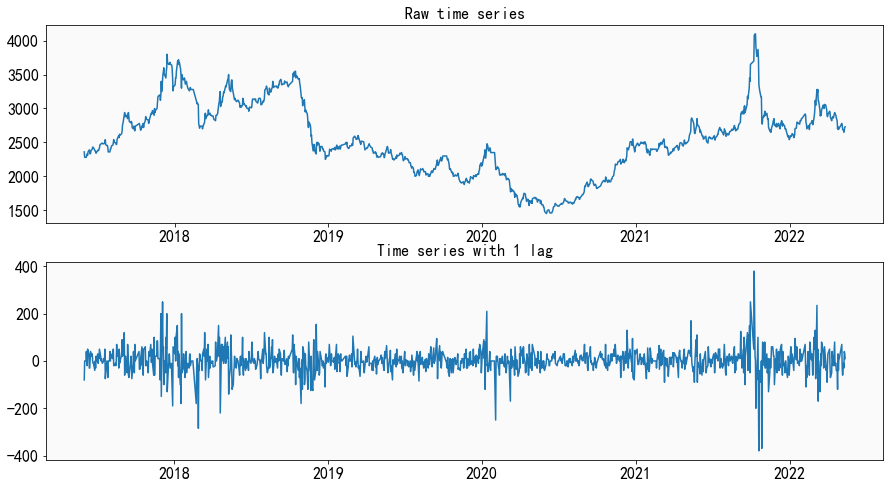

In [18]:
dt.time_series_analysis(actuals_df) 

### Ljung-Box - 随机性检验
> 结论：
    > 1至20阶滞后的序列所得p值均小于0.1，说明我们有90%的置信度认为该序列不是白噪声数据，不具有随机性，因此数据有价值，可以继续分析

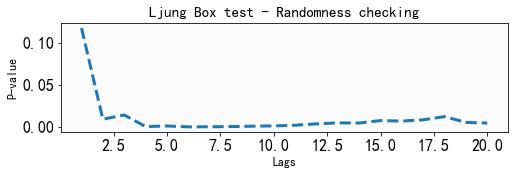

In [19]:
# 对基差进行2阶差分, 并填充后向缺失值
actuals_df['主流现货价格1期差分'] = actuals_df.diff(1).fillna(method='bfill')
# 检验1阶滞后范围内序列的自相关性是否显著（或是否为白噪声）
dt.residual_check(df=actuals_df['主流现货价格1期差分'], lags=20)

## ARIMA模型参数选择

### ACF（自相关性）和PACF（偏自相关性）分析
> 结论：
    > 据下图分析，自相关系数在4附近拖尾，则p=4；偏自相关系数也在4附近拖尾，则q=4 => ARIMA(4,1,4)

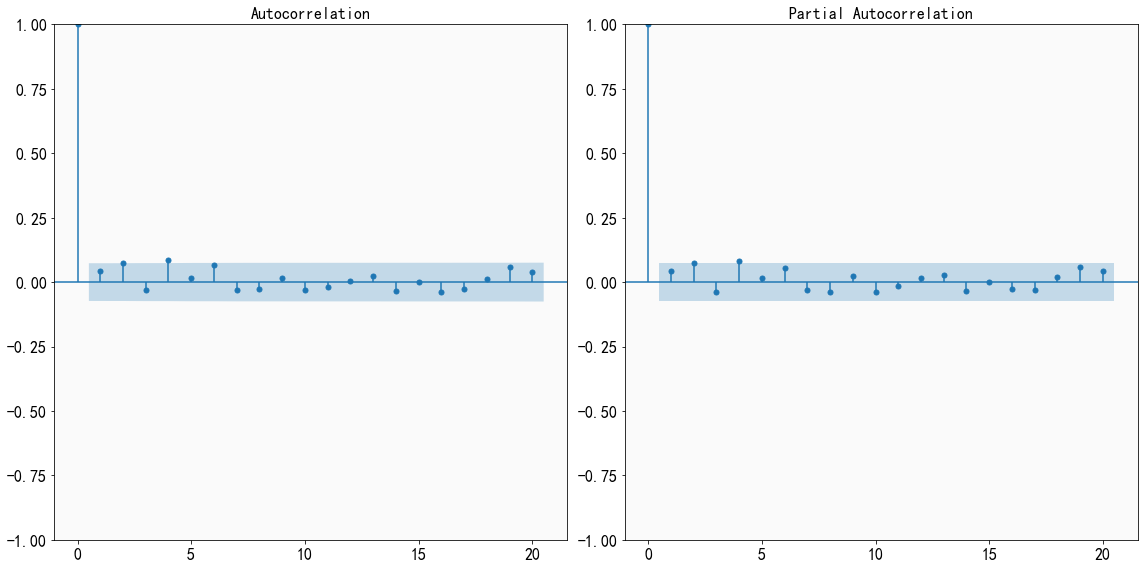

In [20]:
dt.acf_pacf_plot(df=actuals_df['主流现货价格1期差分'], lags=20, alpha=0.01)

### AIC准则 - 对参数进行Grid Search
> 结论：
    > 基于AIC准则，AIC最小时对应的(p,d,q)=(4,1,3),结合ACF和PACF图分析结果，选择(p,d,q)=(4,1,4)

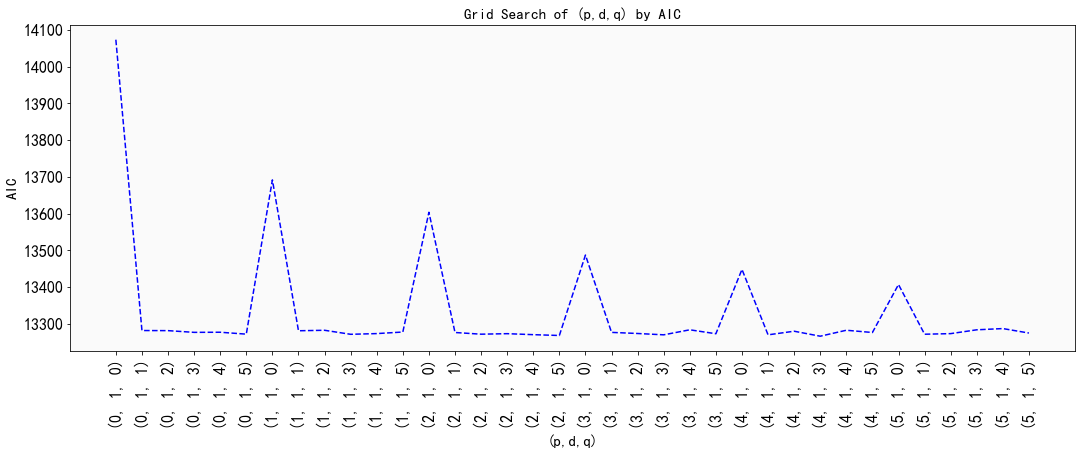

(4, 1, 3)

In [21]:
dt.grid_search_aic_arima(df=actuals_df['主流现货价格1期差分'], p=range(0,6), d=[1], q=range(0, 6), figsize=(18,6))

## 生成直接择时信号
> ARIMA模型训练：
    基于当前交易日前10个历史日收益（相当于2周）滚动构建ARIMA模型，并对当前交易日基差进行预测（样本外进行One-step ahead prediction）

> 阈值设定：
    为当前交易日前一天的基差值
    
> 策略：
    若预测基差大于（小于）阈值, 则在下一期做多（做空）标的期货

### Arima模型训练与预测

In [22]:
# 对每个交易日，使用之前的10个历史日收益（相当于2周）滚动构建ARIMA模型，并对该日的基差预测
direct_signal_df = arima().train_predict(df=actuals_df['主流现货价格1期差分'], window=10, order=(0,1,1), columns=['Index', '主流现货价格1期差分_predict', '主流现货价格1期差分_previous', '主流现货价格1期差分_true'])

#应用策略
position_list = []
for i in range(len(direct_signal_df)):
    position_list.append(-1 if direct_signal_df['主流现货价格1期差分_predict'][i] > direct_signal_df['主流现货价格1期差分_previous'][i] else 1 if direct_signal_df['主流现货价格1期差分_predict'][i] < direct_signal_df['主流现货价格1期差分_previous'][i] else 0)
direct_signal_df = pd.concat([direct_signal_df, pd.DataFrame(position_list, columns=['Position'], index = direct_signal_df.index)], axis=1)
direct_signal_df.head()

,主流现货价格1期差分_predict,主流现货价格1期差分_previous,主流现货价格1期差分_true,Position
Index,,,,
2017-06-14,-13.985697,-30.0,-30.0,-1
2017-06-15,-17.945770,-30.0,10.0,-1
2017-06-16,5.998364,10.0,40.0,1
2017-06-19,9.998915,40.0,20.0,1
2017-06-20,11.998996,20.0,30.0,1


### 甲醇期货主连收益率和净值计算

In [23]:
# 合并数数据
df = direct_signal_df.merge(future_price_df, left_index=True, right_index=True)
# 计算甲醇期货主力合约收益率
df['甲醇期货主连收益率'] = df['甲醇期货主连开盘价'].pct_change().shift(-1)
df['净值'] = (df['Position'] * df['甲醇期货主连收益率'] + 1).cumprod()
df.fillna(method='ffill', inplace=True)
df.head()

,主流现货价格1期差分_predict,主流现货价格1期差分_previous,主流现货价格1期差分_true,Position,甲醇期货主连开盘价,甲醇期货主连收益率,净值
2017-06-14,-13.985697,-30.0,-30.0,-1,2869.634182,0.023581,0.976419
2017-06-15,-17.945770,-30.0,10.0,-1,2937.302412,-0.023891,0.999747
2017-06-16,5.998364,10.0,40.0,1,2867.127951,0.021853,1.021594
2017-06-19,9.998915,40.0,20.0,1,2929.783720,0.016253,1.038198
2017-06-20,11.998996,20.0,30.0,1,2977.402103,-0.010101,1.027712


## 回测
> 结论：
    > 可以看出，择时收益在2020年来跑赢了基准收益，回测期内2020年至2022年，年化收益率分别为10.03%， 29.39%， 21.17%。该择时指标在2017年至2019年期间表现较差，求得负收益。
    

年份         2017      2018      2019      2020      2021      2022
年化收益率 -0.175590  0.291649 -0.180174 -0.061660  0.163526  0.426851
年化波动率  0.022458  0.015873  0.015339  0.020564  0.023086  0.038812
最大回撤率 -0.288101 -0.201376 -0.292975 -0.257221 -0.226116 -0.155682
夏普率   -0.037157  0.080772 -0.044258 -0.004082  0.038613  0.100011
卡玛比率   0.609472 -1.448278  0.614980  0.239717 -0.723198 -2.741821


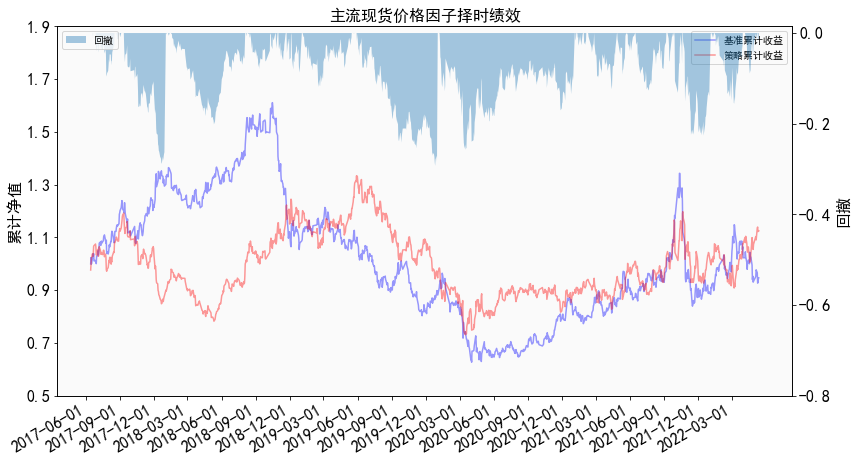

In [29]:
broker_arima = Broker()
broker_arima.set_backtest(df[['甲醇期货主连开盘价', '净值']])  # 回测只需要“甲醇期货主连开盘价”和“净值”
trade_arima = Trade(broker_arima)
trade_arima.extract_year_month_week(is_year=True)
# 计算每日收益率
trade_arima.daily_return()
# 计算基准累计收益
trade_arima.basic_cum_return()
print(trade_arima.factor_summary())
trade_arima.backtest_graph(title="主流现货价格因子择时绩效")

# OLS滚动回归择时模型

In [25]:
# 合并数数据
df_ols = actuals_df.merge(future_price_df, left_index=True, right_index=True)
# 计算甲醇期货主力合约收益率
df_ols['甲醇期货主连收益率'] = df_ols['甲醇期货主连开盘价'].pct_change().shift(-1)
df_ols.head()

,主流现货价格,主流现货价格1期差分,甲醇期货主连开盘价,甲醇期货主连收益率
2017-05-31,2360.0,-80.0,2982.414565,-0.058403
2017-06-01,2280.0,-80.0,2808.231529,0.014726
2017-06-02,2280.0,0.0,2849.584336,-0.025945
2017-06-05,2280.0,0.0,2775.650530,0.012190
2017-06-06,2320.0,40.0,2809.484645,0.026316


##  OLS滚动回归择时模型训练与预测

In [26]:
ret_df = rollingOLS().train_predict(df=df_ols, window = 11, columns=['主流现货价格1期差分', '甲醇期货主连收益率'])

## 甲醇期货主连收益率和净值计算

In [27]:
# 设定阈值（取指标的分位数）
# thresholds = [ret_df.quantile(q)[0] for q in [_.round(2) for _ in np.arange(0.1, 1, 0.1)]]

# 仓位判断
ret_df = pd.concat([ret_df, pd.DataFrame([1 if ret_f > 0 else -1 if ret_f < 0 else 0 for ret_f in ret_df['预测收益率']], columns=['Position'], index = ret_df.index)], axis=1)
print("当前仓位情况：\n", ret_df.groupby(['Position'])['Position'].count())

# 净值计算
ret_df['净值'] = (ret_df['Position'].to_frame() .shift(-2).fillna(method='ffill')['Position'] * ret_df['预测收益率'] + 1).cumprod()
ret_df.fillna(method='ffill', inplace=True)

# 合并数据
ret_df = ret_df.merge(df_ols['甲醇期货主连开盘价'], left_index=True, right_index=True)
ret_df.head()

当前仓位情况：
 Position
-1    584
 1    611
Name: Position, dtype: int64


,预测收益率,Position,净值,甲醇期货主连开盘价
2017-06-14,-0.005827,-1,0.994173,2869.634182
2017-06-15,0.001831,1,0.995993,2937.302412
2017-06-16,0.008388,1,1.004348,2867.127951
2017-06-19,0.007993,1,1.012376,2929.783720
2017-06-20,0.006697,1,1.005596,2977.402103


## 回测

年份         2017      2018      2019      2020      2021      2022
年化收益率  0.736772 -0.064717 -0.192870  0.356687  0.025113  0.526108
年化波动率  0.011771  0.012918  0.013863  0.015210  0.020556  0.035720
最大回撤率 -0.082191 -0.299251 -0.229218 -0.113537 -0.253561 -0.109301
夏普率    0.348106 -0.013280 -0.056368  0.091337  0.013264  0.182860
卡玛比率  -8.964187  0.216262  0.841427 -3.141578 -0.099040 -4.813397


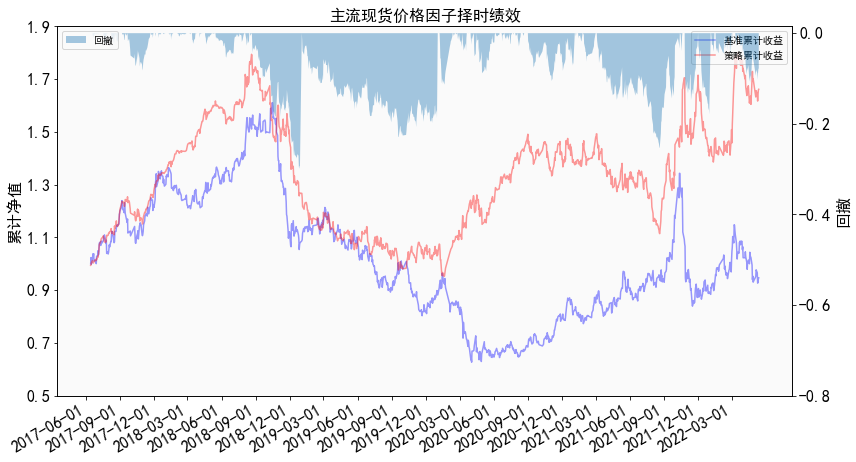

In [30]:
broker_rollingOLS = Broker()
broker_rollingOLS.set_backtest(ret_df[['甲醇期货主连开盘价', '净值']])  # 回测只需要“甲醇期货主连开盘价”和“净值”
trade_rollingOLS = Trade(broker_rollingOLS)
trade_rollingOLS.extract_year_month_week(is_year=True)
# 计算每日收益率
trade_rollingOLS.daily_return()
# 计算基准累计收益
trade_rollingOLS.basic_cum_return()
print(trade_rollingOLS.factor_summary())
trade_rollingOLS.backtest_graph(title="主流现货价格因子择时绩效")